# Tiền xử lý Item

In [27]:
# Cell 1 — Import và hàm hỗ trợ
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [28]:
# ----------- HÀM HỖ TRỢ -----------
def to_float_from_object(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(r'[^0-9.\-]', '', regex=True)
         .replace({'': np.nan, '.': np.nan, '-.': np.nan})
         .astype(float)
    )

def clip_iqr(series: pd.Series, factor: float = 1.5) -> pd.Series:
    if series.isna().all():
        return series
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - factor * iqr, q3 + factor * iqr
    return series.clip(lower, upper)

def is_id_or_timestamp(col: str) -> bool:
    c = col.lower()
    return c.endswith("id") or ("timestamp" in c)


In [ ]:
# Cell 2 — Đọc dữ liệu parquet, lọc theo pattern và lưu ra file CSV
from pathlib import Path
import pandas as pd

def read_all_parquet(dataset_dir: str, pattern: str = "*.parquet", out_csv: str = "raw_items.csv"):
    dataset = Path(dataset_dir)
    
    # Tìm tất cả các file parquet phù hợp pattern và chứa 'item_chunk'
    all_files = sorted([
        p for p in dataset.rglob("*.parquet")
        if ("item_chunk" in p.name.lower() and p.match(pattern))
    ])

    if not all_files:
        raise FileNotFoundError(
            f"No item parquet found in '{dataset_dir}' matching pattern '{pattern}'"
        )

    print(f"Found {len(all_files)} item chunk(s) in '{dataset_dir}'")
    
    # Đọc và gộp các file
    dfs = [pd.read_parquet(f) for f in all_files]
    combined = pd.concat(dfs, ignore_index=True)
    print(f"Combined shape: {combined.shape}")

    # Lưu dữ liệu gốc ra CSV để tham khảo
    combined.to_csv(out_csv, index=False)
    print(f"Raw data saved to: {out_csv}")

    return combined

# --- Ví dụ sử dụng ---
input_dir = r"C:\Users\Tin\Downloads\recommendation dataset"
df_raw = read_all_parquet(input_dir, pattern="*.parquet", out_csv="raw_items.csv")


📁 Found 1 item chunk(s) in 'C:\Users\Tin\Downloads\recommendation dataset'
✅ Combined shape: (27332, 34)
💾 Raw data saved to: raw_items.csv


# Task 1: Loại bỏ các đặc trưng không cần thiết

In [ ]:
# Cell 3 — Task 1: Loại bỏ cột không cần thiết
ITEM_DEFAULT_DROP = [
    "sync_error_message", "sync_status_id", "last_sync_date",
    "updated_date", "is_deleted", "p_id", "category_id", "image_url",
]

def ensure_description_merged(df: pd.DataFrame):
    if "description_new" in df.columns:
        if "description" in df.columns:
            df["description"] = df["description_new"].fillna(df["description"])
        else:
            df["description"] = df["description_new"]
        df.drop(columns=["description_new"], inplace=True)
    return df

def initial_clean_and_drop(df: pd.DataFrame):
    drop_report = {}
    to_drop = []

    if "weight" in df.columns and df["weight"].isna().mean() >= 0.999:
        to_drop.append("weight")
        drop_report["weight"] = "100% missing"

    to_drop.extend([c for c in ITEM_DEFAULT_DROP if c in df.columns])
    df = df.drop(columns=to_drop, errors="ignore")
    drop_report["dropped"] = to_drop
    return df, drop_report

df = ensure_description_merged(df_raw)
df_task1, drop_report = initial_clean_and_drop(df)

print("Sau Task 1:", df_task1.shape)
print("Cột đã loại bỏ:", drop_report)


✅ Sau Task 1: (27332, 24)
🗑️ Cột đã loại bỏ: {'weight': '100% missing', 'dropped': ['weight', 'sync_error_message', 'sync_status_id', 'last_sync_date', 'updated_date', 'is_deleted', 'p_id', 'category_id', 'image_url']}


# Task 2: Xử lý NULL và Outlier

In [ ]:
# Cell 4 — Task 2: Xử lý NULL và Outlier

def basic_impute_and_cap(df: pd.DataFrame, iqr_factor=1.5):
    for c in df.select_dtypes(include=["object"]).columns:
        if df[c].isna().any():
            df[c] = df[c].fillna("Unknown")
    for c in df.select_dtypes(include=[np.number]).columns:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())
    if "price" in df.columns and pd.api.types.is_numeric_dtype(df["price"]):
        df["price"] = clip_iqr(df["price"], factor=iqr_factor)
    return df

df_task2 = basic_impute_and_cap(df_task1.copy())

print("Sau Task 2:", df_task2.shape)
print("Còn NULL không?")
print(df_task2.isna().sum()[df_task2.isna().sum() > 0])


✅ Sau Task 2: (27332, 24)
🔍 Còn NULL không?
Series([], dtype: int64)


# Task 3: Phân tích tương đồng và loại bỏ đặc trưng thừa

C:\Users\Tin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


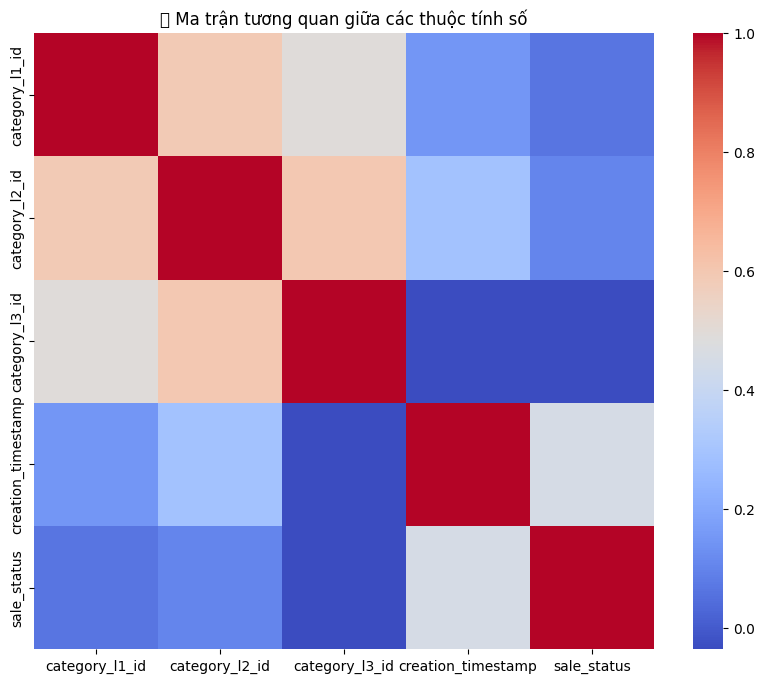

✅ Sau Task 3: (27332, 24)
🗑️ Các cột bị loại do tương quan cao: []


In [ ]:
# Cell 5 — Task 3: Phân tích tương đồng giữa các thuộc tính

corr = df_task2.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Ma trận tương quan giữa các thuộc tính số")
plt.show()

# Loại bỏ thuộc tính có tương quan quá cao (> 0.95)
corr_threshold = 0.95
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column].abs() > corr_threshold)]

df_task3 = df_task2.drop(columns=to_drop_corr, errors="ignore")
print("Sau Task 3:", df_task3.shape)
print("Các cột bị loại do tương quan cao:", to_drop_corr)


# Task 4: Chuẩn hóa dữ liệu

In [ ]:
# Cell 6 — Task 4: Chuẩn hóa và biến đổi dữ liệu

def transform_data(df: pd.DataFrame, low_cardinality_threshold=20):
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if not is_id_or_timestamp(c)]
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()

    # Chuẩn hóa dữ liệu số
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Mã hóa One-hot và Tần suất
    ohe_cols = [c for c in obj_cols if df[c].nunique() <= low_cardinality_threshold]
    freq_cols = [c for c in obj_cols if df[c].nunique() > low_cardinality_threshold]

    df = pd.get_dummies(df, columns=ohe_cols, prefix=ohe_cols, dummy_na=False)

    for c in freq_cols:
        freq_map = df[c].value_counts(normalize=True).to_dict()
        df[c] = df[c].map(freq_map)

    return df

df_task4 = transform_data(df_task3.copy())

print("Sau Task 4:", df_task4.shape)
print(f"Columns ({len(df.columns)}): {list(df.columns)}")
df_task4.head()


✅ Sau Task 4: (27332, 42)
Columns (33): ['p_id', 'item_id', 'price', 'category_l1_id', 'category_l1', 'category_l2_id', 'category_l2', 'category_l3_id', 'category_l3', 'category_id', 'category', 'description', 'brand', 'manufacturer', 'creation_timestamp', 'is_deleted', 'created_date', 'updated_date', 'sync_status_id', 'last_sync_date', 'sync_error_message', 'image_url', 'gender_target', 'age_group', 'item_type', 'gp', 'weight', 'color', 'size', 'origin', 'volume', 'material', 'sale_status']


,item_id,price,category_l1_id,category_l2_id,category_l2,category_l3_id,category_l3,category,description,brand,...,category_l1_Thực phẩm cho bé,category_l1_Thực phẩm cho gia đình,category_l1_Tã,category_l1_Vệ sinh,category_l1_Đồ chơi & Sách,gender_target_Bé Gái,gender_target_Bé Trai,gender_target_Không xác định,gender_target_Sơ sinh,gender_target_Unisex
0,0.000037,0.032124,1,35,0.018916,7050,0.003439,0.000549,0.000037,0.000988,...,False,False,False,False,False,False,False,True,False,False
1,0.000037,0.057113,3292,3958,0.333126,7007,0.188936,0.027111,0.651983,0.017708,...,False,False,False,False,False,True,False,False,False,False
2,0.000037,0.008561,351,2033,0.023928,2118,0.001829,0.000439,0.000037,0.022208,...,False,False,False,False,True,False,False,True,False,False
3,0.000037,0.000768,2222,2272,0.002525,2275,0.001427,0.000256,0.651983,0.001427,...,False,False,True,False,False,False,False,True,False,False
4,0.000037,0.000768,2222,2272,0.002525,2275,0.001427,0.000951,0.651983,0.001427,...,False,False,True,False,False,False,False,True,False,False


# Task 5: Rút trích đặc trưng

| Đặc trưng mới         | Ý nghĩa                                                                   |
| --------------------- | ------------------------------------------------------------------------- |
| `item_age_days`       | Sản phẩm đã tồn tại bao lâu kể từ ngày tạo (`today - creation_timestamp`) |
| `days_since_update`   | Số ngày kể từ lần cập nhật gần nhất (`today - updated_date`)              |
| `days_since_sync`     | Số ngày kể từ lần đồng bộ (`today - last_sync_date`)                      |
| `is_recently_created` | Sản phẩm mới (dưới 30 ngày)                                               |
| `is_recently_updated` | Sản phẩm vừa được cập nhật                                                |


In [34]:
import pandas as pd
from datetime import datetime

today = pd.Timestamp(datetime.now())

df['creation_timestamp'] = pd.to_datetime(df['creation_timestamp'], errors='coerce')
df['updated_date'] = pd.to_datetime(df['updated_date'], errors='coerce')
df['last_sync_date'] = pd.to_datetime(df['last_sync_date'], errors='coerce')

df['item_age_days'] = (today - df['creation_timestamp']).dt.days
df['days_since_update'] = (today - df['updated_date']).dt.days
df['days_since_sync'] = (today - df['last_sync_date']).dt.days

df['is_recently_created'] = (df['item_age_days'] <= 30).astype(int)
df['is_recently_updated'] = (df['days_since_update'] <= 30).astype(int)

print(df[['creation_timestamp', 'updated_date', 'last_sync_date', 'item_age_days', 'days_since_update', 'days_since_sync', 'is_recently_created', 'is_recently_updated']].head())

             creation_timestamp            updated_date  \
0 1970-01-01 00:00:01.333531544 2025-08-18 09:59:19.847   
1 1970-01-01 00:00:01.503046250 2025-09-18 16:05:42.360   
2 1970-01-01 00:00:01.358501584 2025-09-27 00:05:36.233   
3 1970-01-01 00:00:01.400062039 2025-09-27 00:05:36.233   
4 1970-01-01 00:00:01.400062040 2025-09-27 00:05:36.233   

              last_sync_date  item_age_days  days_since_update  \
0 2025-07-18 17:59:29.898256          20375                 57   
1                        NaT          20375                 25   
2 2025-07-18 17:59:29.898256          20375                 17   
3 2025-07-18 17:59:29.898256          20375                 17   
4 2025-07-18 17:59:29.898256          20375                 17   

   days_since_sync  is_recently_created  is_recently_updated  
0             87.0                    0                    0  
1              NaN                    0                    1  
2             87.0                    0                    

| Đặc trưng mới      | Ý nghĩa                                             |
| ------------------ | --------------------------------------------------- |
| `price_per_weight` | Giá trên mỗi gram (hoặc ml)                         |
| `price_log`        | Log-transform của giá (giảm skewness)               |
| `is_premium`       | Sản phẩm thuộc phân khúc cao cấp (giá > ngưỡng 90%) |
| `is_low_cost`      | Sản phẩm rẻ (giá < ngưỡng 10%)                      |


In [35]:
price_n = pd.to_numeric(df.get('price'), errors='coerce').astype(float)
weight_n = pd.to_numeric(df.get('weight'), errors='coerce').astype(float)

price_per_weight = price_n / weight_n.replace({0: np.nan})
df['price_per_weight'] = price_per_weight

q10, q90 = price_n.quantile([0.1, 0.9])
df['is_premium'] = (price_n >= q90).astype(int)
df['is_low_cost'] = (price_n <= q10).astype(int)
print(df[['price', 'weight', 'price_per_weight', 'is_premium', 'is_low_cost']].head())

         price  weight  price_per_weight  is_premium  is_low_cost
0   99000.0000     NaN               NaN           0            0
1   69000.0000     NaN               NaN           0            0
2   45000.0000     NaN               NaN           0            0
3  401000.0000     NaN               NaN           1            0
4  401000.0000     NaN               NaN           1            0


| Đặc trưng mới            | Ý nghĩa                                                      |
| ------------------------ | ------------------------------------------------------------ |
| `brand_popularity`       | Mức độ phổ biến của thương hiệu (đếm số sản phẩm theo brand) |
| `manufacturer_diversity` | Số lượng thương hiệu khác nhau cùng nhà sản xuất             |
| `brand_age_avg`          | Tuổi trung bình sản phẩm trong cùng brand                    |


In [36]:
brand_stats = df.groupby('brand').agg({
    'item_id': 'count',
    'item_age_days': 'mean'
}).reset_index()

brand_stats.columns = ['brand', 'brand_popularity', 'brand_age_avg']

manu_stats = df.groupby('manufacturer')['brand'].nunique().reset_index()
manu_stats.columns = ['manufacturer', 'manufacturer_diversity']

df = df.merge(brand_stats, on='brand', how='left')
df = df.merge(manu_stats, on='manufacturer', how='left')
print(df[['brand', 'brand_popularity', 'brand_age_avg', 'manufacturer', 'manufacturer_diversity']].head())

              brand  brand_popularity  brand_age_avg    manufacturer  \
0        Dr.Brown's                27        20375.0  Không xác định   
1          Con Cưng               484        20375.0  Không xác định   
2  Thương hiệu khác               607        20375.0  Không xác định   
3      Merries Nhật                39        20375.0  Không xác định   
4      Merries Nhật                39        20375.0  Không xác định   

   manufacturer_diversity  
0                     860  
1                     860  
2                     860  
3                     860  
4                     860  


| Đặc trưng mới         | Ý nghĩa                                       |
| --------------------- | --------------------------------------------- |
| `category_depth`      | Cấp độ phân loại sâu nhất có dữ liệu          |
| `category_full_path`  | Gộp 3 cấp category lại thành 1 chuỗi duy nhất |
| `category_popularity` | Tổng số sản phẩm trong cùng category cấp 3    |


In [37]:
df['category_depth'] = df[['category_l1', 'category_l2', 'category_l3']].notnull().sum(axis=1)
df['category_full_path'] = df['category_l1'].fillna('') + '>' + \
                           df['category_l2'].fillna('') + '>' + \
                           df['category_l3'].fillna('')

cat_pop = df.groupby('category_l3')['item_id'].count().reset_index()
cat_pop.columns = ['category_l3', 'category_popularity']
df = df.merge(cat_pop, on='category_l3', how='left')
print(df[['category_l1', 'category_l2', 'category_l3', 'category_depth', 'category_full_path', 'category_popularity']].head())

      category_l1         category_l2                    category_l3  \
0        Babycare  Bình sữa, phụ kiện                         Núm ty   
1      Thời trang      Cơ cấu hàng cũ  Thời trang bé trai, bé gái cũ   
2  Đồ chơi & Sách                0-1Y                       Gặm nướu   
3              Tã             Merries                        Merries   
4              Tã             Merries                        Merries   

   category_depth                                 category_full_path  \
0               3                 Babycare>Bình sữa, phụ kiện>Núm ty   
1               3  Thời trang>Cơ cấu hàng cũ>Thời trang bé trai, ...   
2               3                       Đồ chơi & Sách>0-1Y>Gặm nướu   
3               3                                 Tã>Merries>Merries   
4               3                                 Tã>Merries>Merries   

   category_popularity  
0                   94  
1                 5164  
2                   50  
3                   39  
4        

| Đặc trưng mới        | Ý nghĩa                                    |
| -------------------- | ------------------------------------------ |
| `is_gender_specific` | Sản phẩm nhắm theo giới tính               |
| `is_age_specific`    | Có nhóm tuổi mục tiêu                      |
| `is_general_use`     | Sản phẩm dùng chung (không phân giới/tuổi) |


In [38]:
df['is_gender_specific'] = df['gender_target'].notnull().astype(int)
df['is_age_specific'] = df['age_group'].notnull().astype(int)
df['is_general_use'] = ((df['gender_target'].isnull()) & (df['age_group'].isnull())).astype(int)
print(df[['gender_target', 'is_gender_specific', 'age_group', 'is_age_specific', 'is_general_use']].head())

    gender_target  is_gender_specific       age_group  is_age_specific  \
0  Không xác định                   1  Không xác định                1   
1          Bé Gái                   1           Từ 3Y                1   
2  Không xác định                   1  Không xác định                1   
3  Không xác định                   1  Không xác định                1   
4  Không xác định                   1  Không xác định                1   

   is_general_use  
0               0  
1               0  
2               0  
3               0  
4               0  


In [ ]:
output_path = "item_features_enhanced.csv"
df.to_csv(output_path, index=False)

print("Task 5 (Item Feature Engineering) hoàn tất.")
print(f"Final shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")


✅ Task 5 (Item Feature Engineering) hoàn tất.
Final shape: (27332, 50)
Columns (50): ['p_id', 'item_id', 'price', 'category_l1_id', 'category_l1', 'category_l2_id', 'category_l2', 'category_l3_id', 'category_l3', 'category_id', 'category', 'description', 'brand', 'manufacturer', 'creation_timestamp', 'is_deleted', 'created_date', 'updated_date', 'sync_status_id', 'last_sync_date', 'sync_error_message', 'image_url', 'gender_target', 'age_group', 'item_type', 'gp', 'weight', 'color', 'size', 'origin', 'volume', 'material', 'sale_status', 'item_age_days', 'days_since_update', 'days_since_sync', 'is_recently_created', 'is_recently_updated', 'price_per_weight', 'is_premium', 'is_low_cost', 'brand_popularity', 'brand_age_avg', 'manufacturer_diversity', 'category_depth', 'category_full_path', 'category_popularity', 'is_gender_specific', 'is_age_specific', 'is_general_use']
